In [2]:
# need to run this twice due to bug in imported package

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys

sys.path.append("../")
from protocols import Helpers
from protocols.BuildCatalogue import BuildCatalogue

from protocols.Predict import piezo_predict, piezo_predict_cv

import warnings
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

What are we doing here? 
- How prevalent is mmpL5 I948V?
- FRS vs performance with mmpL5 I948V
- FRS vs performance without mmpL5 I948V
- Catalogue comparison at high vs low FRS without mmpL5 I948V to explain results
- FRS vs performance without mmpL5


## Data imports

In [98]:
mutations = pd.read_csv('./data/cryptic2_rev2/bdq_mutations.csv', index_col=0)
genomes = pd.read_pickle("./data/cryptic2_rev2/GENOMES.pkl.gz").reset_index()
phenotypes = pd.read_pickle("./data/cryptic2_rev2/DST_MEASUREMENTS.pkl.gz").reset_index()


## Data prep for catalogue building

In [99]:
#filter plates (only) for high quality phenotypes
phenotypes = phenotypes[
    (phenotypes.DRUG == 'BDQ') & 
    (
        ((phenotypes.METHOD_3=='MGIT960') & (phenotypes.SOURCE=='NICD'))| 
        ((phenotypes.QUALITY.isin(['HIGH'])))
    ) & 
    (~phenotypes.METHOD_MIC.isna()) & 
    (~phenotypes.PHENOTYPE.isna())
]

#create Gene@Mutation
mutations['GENE_MUT'] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1
)
mutations['IS_SYNONYMOUS'] = mutations['MUTATION'].apply(lambda x: x[0] == x[-1])
mutations['FRS'] = mutations.apply(
    lambda x: 1 if not x['IS_MINOR_ALLELE'] else x['FRS'],
    axis=1
)

# Filter out synonymous mutations
cat_mutations = mutations[~mutations['IS_SYNONYMOUS']].copy()

# Merge genomes and phenotypes tables
samples = pd.merge(
    genomes, 
    phenotypes, 
    on='UNIQUEID', 
    how='inner'
)[['UNIQUEID', 'DRUG', 'PHENOTYPE', 'METHOD_MIC']]

piezo_wildcards = {
    "Rv0678@*=": {"pred": "S", "evid": {}},
    "Rv0678@-*_indel": {"pred": "U", "evid": {}},
    "Rv0678@*_indel": {"pred": "U", "evid": {}},
    "Rv0678@-*?": {"pred": "U", "evid": {}},
    "Rv0678@*?": {"pred": "U", "evid": {}},
    "Rv0678@del_0.0": {"pred": "U", "evid": {}},
    "pepQ@*=": {"pred": "S", "evid": {}},
    "pepQ@-*_indel": {"pred": "U", "evid": {}},
    "pepQ@*_indel": {"pred": "U", "evid": {}},
    "pepQ@-*?": {"pred": "U", "evid": {}},
    "pepQ@*?": {"pred": "U", "evid": {}},
    "pepQ@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@*=": {"pred": "S", "evid": {}},
    "mmpS5@-*_indel": {"pred": "U", "evid": {}},
    "mmpS5@*_indel": {"pred": "U", "evid": {}},
    "mmpS5@-*?": {"pred": "U", "evid": {}},
    "mmpS5@*?": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpL5@*=": {"pred": "S", "evid": {}},
    "mmpL5@-*_indel": {"pred": "U", "evid": {}},
    "mmpL5@*_indel": {"pred": "U", "evid": {}},
    "mmpL5@-*?": {"pred": "U", "evid": {}},
    "mmpL5@*?": {"pred": "U", "evid": {}},
    "mmpL5@del_0.0": {"pred": "U", "evid": {}},
    "atpE@*=": {"pred": "S", "evid": {}},
    "atpE@-*_indel": {"pred": "U", "evid": {}},
    "atpE@*_indel": {"pred": "U", "evid": {}},
    "atpE@-*?": {"pred": "U", "evid": {}},
    "atpE@*?": {"pred": "U", "evid": {}},
    "atpE@RFill": {"pred": "R", "evid": {}},
    "atpE@del_0.0": {"pred": "U", "evid": {}},
}


We use high quality phenotypes due to low signal in CRypTIC 1, and therefore good chance of FP. So get rid of them. 

## Basic Numbers

### Non-wt samples - used to build catalogues 

In [100]:
all_cat = pd.merge(cat_mutations, phenotypes, on=["UNIQUEID"], how="inner")
Helpers.CombinedDataTable((all_cat))

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   555  10709  11260           185  315   499  1711  21604  23315   
mmpL5   555  10705  11260             8  171   179  1026  20455  21481   
Rv0678  486    436    922           174   97   271   647    508   1155   
pepQ     21    218    239            12   69    81    27    437    464   
mmpS5     2     59     61             1    3     4     3     62     65   
atpE      8     19     27             3    6     9     8    142    150   

       Minor alleles             
                   R    S Total  
Total            361  590   951  
mmpL5             23  254   277  
Rv0678           315  146   461  
pepQ              18   77    95  
mmpS5              2    3     5  
atpE               3  110   113

All 11260 non-wt samples contain an mmpL5 non-synonymous variant - this corresponds to 21481 mutations in mmpL5 in total.

### All samples - used to test catalogues (include wt and synonymous)

In [101]:
all = pd.merge(samples, mutations, on=["UNIQUEID"], how="left")
all['GENE'].fillna('None', inplace=True)
Helpers.CombinedDataTable((all))

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   558  10804  11358           185  315   499  1742  22598  24340   
mmpL5   555  10707  11262             8  171   179  1053  21011  22064   
Rv0678  486    457    943           174   97   271   647    532   1179   
pepQ     21    278    299            12   69    81    27    709    736   
mmpS5     2     80     82             1    3     4     3     84     87   
atpE      9     30     39             3    6     9     9    169    178   
None      3     92     95             0    0     0     3     93     96   

       Minor alleles             
                   R    S Total  
Total            361  590   951  
mmpL5             23  254   277  
Rv0678           315  146   461  
pepQ              18   77    95  
mmpS5              2    3     5  
atpE               3  110   113  
None               0    0     0

### How many samples contain an mmpL5 I948V mutation?

In [102]:
all[all.GENE_MUT=='mmpL5@I948V'].UNIQUEID.nunique()/all.UNIQUEID.nunique()

0.9898749779890826

Pretty well all of them.... suggests mmpL5@I948V is a phylogenetic mutation. This is supported by https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-020-00726-5#Sec14.

Pretty embarassing I didn't pick this up earlier - driven by realisation of how important recognising phylogenetic mutations may be for the catalogue building method for other drugs.

## FRS vs Performance with mmpL5@I948V (same as before)

[[  398   138    18]
 [  110 10651    43]]
Catalogue coverage of isolates: 0.9946293361507308
Sensitivity: 0.7425373134328358
Specificity: 0.9897779016819999
[[  401   136    17]
 [  112 10648    44]]
Catalogue coverage of isolates: 0.9946293361507308
Sensitivity: 0.7467411545623837
Specificity: 0.9895910780669145
[[  402   135    17]
 [  113 10646    45]]
Catalogue coverage of isolates: 0.9945412924810706
Sensitivity: 0.7486033519553073
Specificity: 0.9894971651640487
[[  399   136    19]
 [  113 10644    47]]
Catalogue coverage of isolates: 0.99418911780243
Sensitivity: 0.7457943925233644
Specificity: 0.9894952124198196
[[  399   136    19]
 [  113 10638    53]]
Catalogue coverage of isolates: 0.993660855784469
Sensitivity: 0.7457943925233644
Specificity: 0.989489349827923
[[  397   138    19]
 [  111 10640    53]]
Catalogue coverage of isolates: 0.993660855784469
Sensitivity: 0.7420560747663552
Specificity: 0.9896753790345084
[[  383   150    21]
 [  102 10651    51]]
Catalogue cove

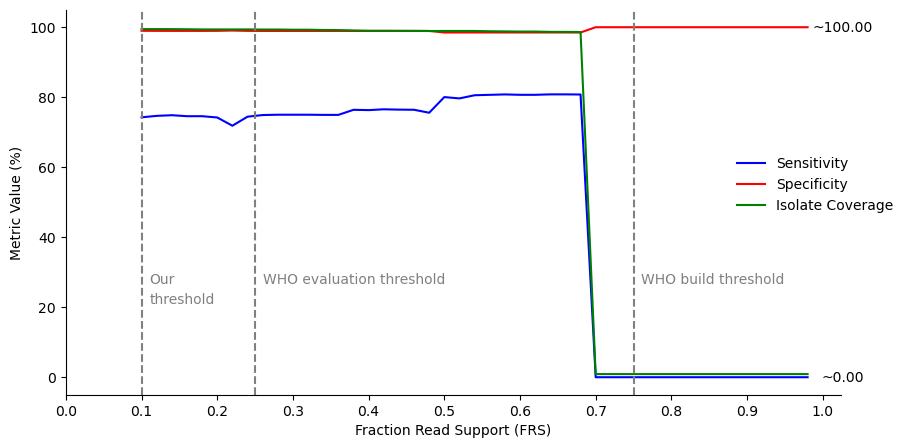

In [104]:
sens, spec, cov, FNs = [], [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.02):
    #Build and save catalogue
    BuildCatalogue(samples, cat_mutations, i).return_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2024.01", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/manuscript_2/rethink/with_I948V/catalogue_FRS_{int(i*100)}.csv", index=False)
    #predict with catalogue
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all,
        f"./catalogues/manuscript_2/rethink/with_I948V/catalogue_FRS_{int(i*100)}.csv",
        "BDQ",
        Print=True,
    )
    sens.append(_sens*100)
    spec.append(_spec*100)
    cov.append(_cov*100)
    FNs.append(_FN_ids)
    FRS.append(i)
data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov, "FNs":FNs}
)

Helpers.FRS_vs_metric(data)

These results suggest minor alleles are significant in the context of BDQ-relevant genes, and that there is a switch around FRS 0.66 where sufficient minor alleles are allowed in to allow correct classification of mmpL5@I948V.

However, as mentioned mmpL5@I948V is present in pretty well all samples, and is correctly classified as susceptible at low FRS. Literature suggests its phylogenetic (along with mmpL5@T794I) and therefore in theory we can remove it (/call it S) and expect the same performance at high FRS as achieved when including it at low FRS, if it is indeed the main culprit.

## FRS vs Performance without mmpL5@I948V 

Hardcode I948V as susceptible - assumption is phylogenetic

[[  398   138    18]
 [  110 10651    43]]
Catalogue coverage of isolates: 0.9946293361507308
Sensitivity: 0.7425373134328358
Specificity: 0.9897779016819999
[[  401   136    17]
 [  112 10648    44]]
Catalogue coverage of isolates: 0.9946293361507308
Sensitivity: 0.7467411545623837
Specificity: 0.9895910780669145
[[  402   135    17]
 [  113 10646    45]]
Catalogue coverage of isolates: 0.9945412924810706
Sensitivity: 0.7486033519553073
Specificity: 0.9894971651640487
[[  399   136    19]
 [  113 10644    47]]
Catalogue coverage of isolates: 0.99418911780243
Sensitivity: 0.7457943925233644
Specificity: 0.9894952124198196
[[  399   136    19]
 [  113 10638    53]]
Catalogue coverage of isolates: 0.993660855784469
Sensitivity: 0.7457943925233644
Specificity: 0.989489349827923
[[  397   138    19]
 [  111 10640    53]]
Catalogue coverage of isolates: 0.993660855784469
Sensitivity: 0.7420560747663552
Specificity: 0.9896753790345084
[[  383   150    21]
 [  102 10651    51]]
Catalogue cove

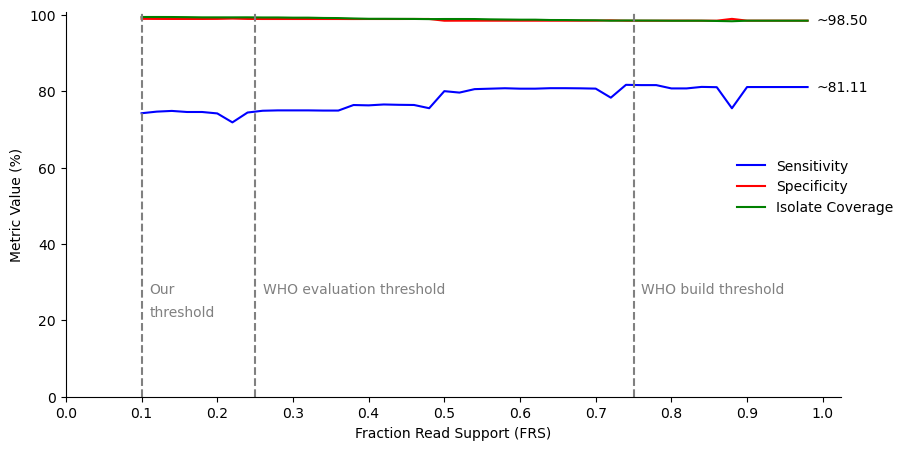

In [105]:
sens, spec, cov, FNs = [], [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.02):
    #Build and save catalogue
    BuildCatalogue(samples, cat_mutations, i, hardcoded={'mmpL5@I948V':'S'}).return_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2024.01", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/manuscript_2/rethink/without_I948V/catalogue_FRS_{int(i*100)}.csv", index=False)
    #predict with catalogue
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all,
        f"./catalogues/manuscript_2/rethink/without_I948V/catalogue_FRS_{int(i*100)}.csv",
        "BDQ",
        Print=True,
    )
    sens.append(_sens*100)
    spec.append(_spec*100)
    cov.append(_cov*100)
    FNs.append(_FN_ids)
    FRS.append(i)
data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov, "FNs":FNs}
)

Helpers.FRS_vs_metric(data)

Seeding the method with mmpL5@I948V achieves very good performance across the FRS range - suggests this was the primary issue all along (how depressing)

These results support the idea the mmpL5@I948V is phylogenetic and has no impact on the phenotype - calling mmpL5@I948V susceptible raises sensitivity to around 74-80% across the FRS range.

Coverage does increase as expected - however the relative difference is small as dropping the FRS drops the number of unknown predictions to almost a third of that at high FRS, but this corresponds to around 100 additional samples (and there are ~11300 total).

It's concerning that decreasing FRS raises coverage but lowers sensitivity. False negatives can arise in 2 ways - new mutations are allowed in which are incorrectly classified, or mutations which were R or U are now S. What mutations are allowed in at low FRS that weren't at high FRS? Which mutations have their phenotype changed? Why have they dropped the sensitivity?

Firslty. Are the additional mutations we get from dropping the FRS being incorrectly classified as S?

In [110]:
frs_10 = pd.read_csv('./catalogues/manuscript_2/rethink/without_I948V/catalogue_FRS_10.csv')
frs_90 = pd.read_csv('./catalogues/manuscript_2/rethink/without_I948V/catalogue_FRS_90.csv')

added = list(set(frs_10.MUTATION) - set(frs_90.MUTATION))
added = frs_10[frs_10.MUTATION.isin(added)][['MUTATION', 'PREDICTION']]

added.PREDICTION.value_counts()


S    100
R     32
Name: PREDICTION, dtype: int64

Most additional mutations have been classified as suscpetible - I suspect a number of these are probably incorrect, and hence lead to false negatives. Lets find the overlap between false negatives and minor alleles (or additional mutations), and examine those samples:

In [111]:
minor_allele_FN_ids = all[(all.UNIQUEID.isin(data[data.FRS==0.10].FNs[0]))&(all.GENE_MUT.isin(added.MUTATION))].UNIQUEID.tolist()
FN_samples = all[all.UNIQUEID.isin(minor_allele_FN_ids)][['UNIQUEID', 'PHENOTYPE', 'GENE_MUT']]
FN_samples['added'] = [True if i in added.MUTATION.tolist() else False for i in FN_samples.GENE_MUT]
FN_samples = pd.merge(FN_samples, frs_10, left_on='GENE_MUT', right_on='MUTATION', how='left')[['UNIQUEID', 'PHENOTYPE', 'GENE_MUT', 'PREDICTION', 'added']].rename(columns={'PREDICTION':'MUT_PREDICTION'})
FN_samples

,UNIQUEID,PHENOTYPE,GENE_MUT,MUT_PREDICTION,added
0,site.10.subj.PQ00397108.lab.PQ00397108.iso.1,R,mmpL5@P355P,S,True
1,site.10.subj.PQ00397108.lab.PQ00397108.iso.1,R,mmpL5@I948V,S,False
2,site.10.subj.PQ00397108.lab.PQ00397108.iso.1,R,Rv0678@M146T,S,False
3,site.10.subj.PQ00388362.lab.PQ00388362.iso.1,R,mmpL5@P355P,S,True
4,site.10.subj.PQ00388362.lab.PQ00388362.iso.1,R,mmpL5@I948V,S,False
5,site.10.subj.PQ00388362.lab.PQ00388362.iso.1,R,Rv0678@M146T,S,False
6,site.10.subj.IH00656550.lab.IH00656550.iso.1,R,Rv0678@192_ins_g,S,False
7,site.10.subj.IH00656550.lab.IH00656550.iso.1,R,mmpL5@P355P,S,True
8,site.10.subj.IH00656550.lab.IH00656550.iso.1,R,mmpL5@I948V,S,False
9,site.10.subj.XD02735916.lab.XD02735916.iso.1,R,Rv0678@192_ins_g,S,False


So these are false negative samples that contain a mutation that is added to the catalogue by dropping the FRS. There are only 9 samples that could have been affected by this, and only 2 added mutatations causing it (mmpL5@P355P and Rv0678@F79S). There's something missing - this doesn't explain the high number of FNs.

We also get FNs as a more indirect result of introducing minor alleles into the catalogue building step, which means some mutations come out of the wash with a different phenotype (either from U to S or R to S). Let's test this - are there any mutations present at both FRS extremes that hae their classification changed?

In [112]:
#determine which mutations (that are present at all FRS) have different phenotypes at FRS extremes
frs_merged = pd.merge(frs_90, frs_10, how='inner', on='MUTATION', suffixes=('_df1', '_df2'))
frs_merged['alt_prediction'] = frs_merged['PREDICTION_df1'] != frs_merged['PREDICTION_df2']
frs_merged = frs_merged[frs_merged.alt_prediction][['MUTATION', 'PREDICTION_df1', 'PREDICTION_df2']]
frs_merged


,MUTATION,PREDICTION_df1,PREDICTION_df2
270,Rv0678@L32S,S,R
307,Rv0678@S68G,S,R
381,Rv0678@192_ins_g,R,S
385,Rv0678@R94W,R,S
391,Rv0678@423_ins_c,R,S
401,Rv0678@G121R,R,S
468,Rv0678@R90C,U,S
469,atpE@E61D,U,S
470,Rv0678@M139I,U,S
471,Rv0678@Q51R,U,S


These are the mutations whose classifications switched on the FRS drop - 8 of these could contribute to FNs.

How prevelant are these among the false negatives?

In [113]:
pheno_changed_FN_ids = all[(all.UNIQUEID.isin(data[data.FRS==0.10].FNs[0]))&(all.GENE_MUT.isin(frs_merged[frs_merged.PREDICTION_df2=='S'].MUTATION))].UNIQUEID.tolist()
FN_samples = all[all.UNIQUEID.isin(pheno_changed_FN_ids)][['UNIQUEID', 'PHENOTYPE', 'GENE_MUT']]
FN_samples['changed'] = [True if i in frs_merged.MUTATION.tolist() else False for i in FN_samples.GENE_MUT]
FN_samples = pd.merge(FN_samples, frs_10, left_on='GENE_MUT', right_on='MUTATION', how='left')[['UNIQUEID', 'PHENOTYPE', 'GENE_MUT', 'PREDICTION', 'changed']].rename(columns={'PREDICTION':'MUT_PREDICTION'})
FN_samples

,UNIQUEID,PHENOTYPE,GENE_MUT,MUT_PREDICTION,changed
0,site.04.subj.00206.lab.634028.iso.1,R,mmpL5@D767N,S,False
1,site.04.subj.00206.lab.634028.iso.1,R,mmpL5@T794I,S,False
2,site.04.subj.00206.lab.634028.iso.1,R,mmpL5@I948V,S,False
3,site.04.subj.00206.lab.634028.iso.1,R,atpE@E61D,S,True
4,site.10.subj.UH01308743.lab.UH01308743.iso.1,R,mmpL5@T794I,S,False
...,...,...,...,...,...
132,site.06.subj.JHL_0085-14.lab.06MIL0348.iso.1,R,mmpL5@T794I,S,False
133,site.06.subj.JHL_0085-14.lab.06MIL0348.iso.1,R,mmpL5@I948V,S,False
134,site.06.subj.SGD_0087-14.lab.06MIL0412.iso.1,R,mmpL5@T794I,S,False
135,site.06.subj.SGD_0087-14.lab.06MIL0412.iso.1,R,mmpL5@I948V,S,False


In [114]:
FN_samples.UNIQUEID.nunique()

47

There are 47 FN samples at FRS 0.1 (and not 0.9) that contain mutations whose classification changed to susceptible when dropping the FRS. ie 47 of the false negative samples at FRS 0.1 are due to mutations whose classification switched from either R --> S or U --> S

Therefore, we have 9 false negative samples resulting from new mutations being added and 47 false negatives from mutations' phenotypes changing. Given the difference in number of false negatives between FRS 0.9 and FRS 0.1 is 43, I would argue these mutations explain the drop the in sensitivity from FRS 0.9 --> 0.1 (with some float to allow some samples' predictions changing from S --> R ). The numbers make sense - I don't think there's a bug (and theres not much point comparing true positives, as FRS 0.1 has fewer than FRS 0.9 due to the increase in FNs).

However, what if we convert our U predictions to S? This should decrease the change in sensitivity we see, as at FRS 0.9 there will be more FNs anyway - some of these will correct when dropping the FRS and some will be added (from R).

### Combine U and S predictions and see if this mirrors the WHO results more closely

[[  398   156]
 [  110 10694]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.7184115523465704
Specificity: 0.9898185857089967
[[  401   153]
 [  112 10692]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.723826714801444
Specificity: 0.9896334690855239
[[  402   152]
 [  113 10691]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.7256317689530686
Specificity: 0.9895409107737875
[[  399   155]
 [  113 10691]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.720216606498195
Specificity: 0.9895409107737875
[[  399   155]
 [  113 10691]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.720216606498195
Specificity: 0.9895409107737875
[[  397   157]
 [  111 10693]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.7166064981949458
Specificity: 0.9897260273972602
[[  383   171]
 [  102 10702]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.6913357400722022
Specificity: 0.9905590522028879
[[  399   155]
 [  112 10692]]
Catalogue coverage of isolates: 1.0
Sensitivity: 0.7202

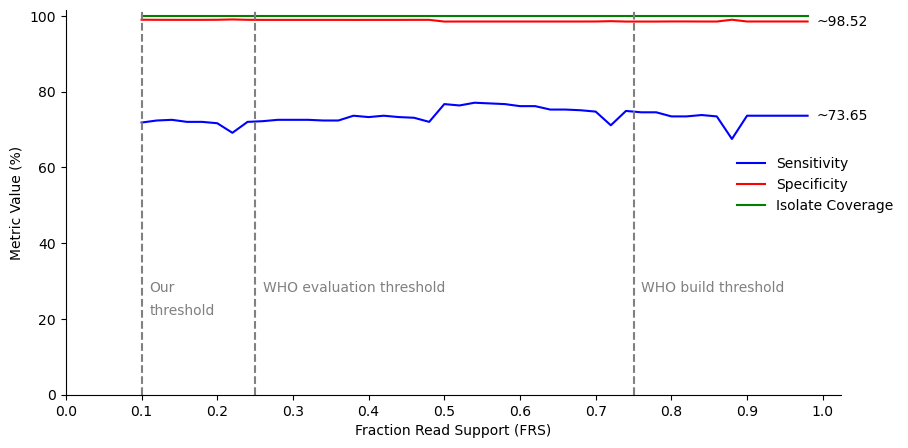

In [115]:
sens, spec, cov = [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.02):
    cm, _cov, _sens, _spec, _ = piezo_predict(
        all,
        f"./catalogues/manuscript_2/rethink/without_I948V/catalogue_FRS_{int(i*100)}.csv",
        "BDQ",
        Print=True,
        U_to_S=True,
    )
    sens.append(_sens*100)
    spec.append(_spec*100)
    cov.append(_cov*100)
    FRS.append(i)

data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov}
)

Helpers.FRS_vs_metric(data)



Our sensitivity now moves between a more constrained range (0.69-0.75) than when using the 'U' classification column. 

However, all mmpL5 mutations are being classified as susceptible - suggests mmpL5 does not contribute towards a resistant phenotype - lets remove altogether and see how we do.

## FRS vs Performance without mmpL5

[[  420   113    21]
 [  118 10587    99]]
Catalogue coverage of isolates: 0.9894347596407819
Sensitivity: 0.7879924953095685
Specificity: 0.9889771134983653
[[  423   111    20]
 [  120 10584   100]]
Catalogue coverage of isolates: 0.9894347596407819
Sensitivity: 0.7921348314606742
Specificity: 0.9887892376681614
[[  423   111    20]
 [  120 10581   103]]
Catalogue coverage of isolates: 0.9891706286318014
Sensitivity: 0.7921348314606742
Specificity: 0.9887860947574993
[[  421   112    21]
 [  120 10581   103]]
Catalogue coverage of isolates: 0.9890825849621412
Sensitivity: 0.7898686679174484
Specificity: 0.9887860947574993
[[  420   117    17]
 [  117 10660    27]]
Catalogue coverage of isolates: 0.9961260785349534
Sensitivity: 0.7821229050279329
Specificity: 0.9891435464414958
[[  424   115    15]
 [  120 10658    26]]
Catalogue coverage of isolates: 0.9963902095439338
Sensitivity: 0.7866419294990723
Specificity: 0.9888662089441455
[[  423   112    19]
 [  122 10646    36]]
Catalogue

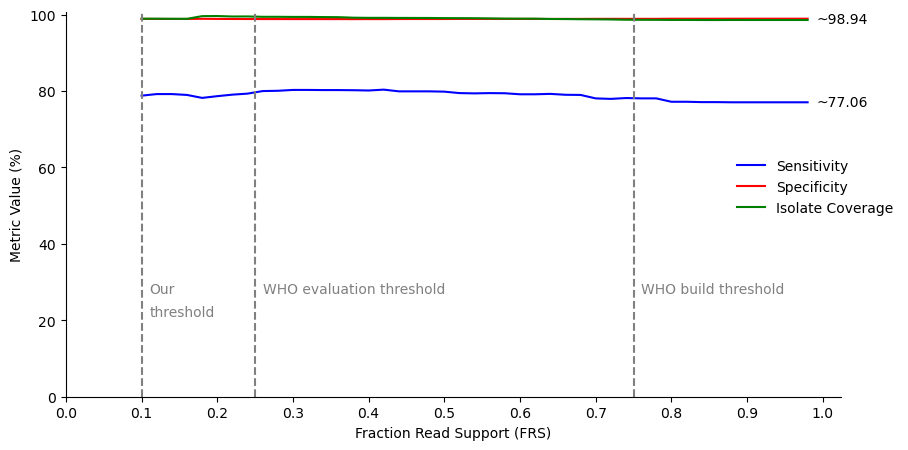

In [116]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue building
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]

sens, spec, cov = [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.02):
    #Build and save catalogue
    BuildCatalogue(samples, mutations_no_mmpL5, i).return_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2024.01", "1.1", "BDQ", piezo_wildcards
    ).to_csv(f"./catalogues/manuscript_2/rethink/without_mmpL5/catalogue_FRS_{int(i*100)}.csv", index=False)
    #predict with catalogue
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all_WT_mmpL5,
        f"./catalogues/manuscript_2/rethink/without_mmpL5/catalogue_FRS_{int(i*100)}.csv",
        "BDQ",
        Print=True,
    )
    sens.append(_sens*100)
    spec.append(_spec*100)
    cov.append(_cov*100)
    FRS.append(i)

data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov}
)

Helpers.FRS_vs_metric(data)

Removing mmpL5 altogether results in a really good performance across the FRS range, with minimal change in sensitivity or coverage.

## Summary

If we take the WHO's catalogue at face value and include all candidate genes, we need to drop the FRS threshold to allow enough Rv0678 minor alleles in to classify mmpL5@I948V correclty and achieve good sensitivity.

However, if we assume mmpL5@I948V is phylogenetic (for which there is literature evidence - and it makes sense as is in every sample) and should have no effect on the phenotype, we can assume its susceptible, which negates the need to alter the FRS threshold. One could argue dropping FRS is benefical anyway as we should get less U's, and this is true but the increase in coverage is minimal (~1%) and it comes at the cost of decreased sensitivity due to (probable) misclassification of an additional 10 mutations (2 came in with the FRS drop, 8 were reclassified).

Removing mmpL5 altogether makes sense, both biologically and in terms of the numbers - we get better, very stable performance across the FRS range. 

Whichever protocol we decide is suitable (regarding I948V or mmpL5 or U -->S) will still be better, cleaner, and easier than the WHOv2.

